In [1]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [2]:
#|default_exp agents.dqn.basic

In [4]:
#|export
# Python native modules
import os
from collections import deque
from typing import Callable,Optional,List
# Third party libs
from fastcore.all import ifnone
import torchdata.datapipes as dp
from torchdata.dataloader2 import DataLoader2
from torchdata.dataloader2.graph import traverse_dps,DataPipe
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
import numpy as np
# Local modules
from fastrl.agents.core import AgentHead,AgentBase
from fastrl.pipes.core import find_dp
from fastrl.memory.experience_replay import ExperienceReplay
from fastrl.agents.core import StepFieldSelector,SimpleModelRunner,NumpyConverter
from fastrl.agents.discrete import EpsilonCollector,PyPrimativeConverter,ArgMaxer,EpsilonSelector
from fastrl.loggers.core import (
    LogCollector,Record,BatchCollector,EpochCollector,RollingTerminatedRewardCollector,EpisodeCollector,is_record
)
from fastrl.learner.core import LearnerBase,LearnerHead,StepBatcher
from fastrl.torch_core import Module

# DQN Basic
> Core DQN modules, pipes, and tooling

## Model

In [5]:
#|export
class DQN(Module):
    def __init__(
            self,
            state_sz:int,  # The input dim of the state
            action_sz:int, # The output dim of the actions
            hidden=512,    # Number of neurons connected between the 2 input/output layers
            head_layer:Module=nn.Linear, # DQN extensions such as Dueling DQNs have custom heads
            activition_fn:Module=nn.ReLU # The activiation fn used by `DQN`
        ):
        self.layers=nn.Sequential(
            nn.Linear(state_sz,hidden),
            activition_fn(),
            head_layer(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)


## Agent

In [6]:
#|export
DataPipeAugmentationFn = Callable[[DataPipe],Optional[DataPipe]]

def DQNAgent(
    model,
    min_epsilon=0.02,
    max_epsilon=1,
    max_steps=1000,
    device='cpu',
    do_logging:bool=False,
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
)->AgentHead:
    agent_base = AgentBase(model)
    agent = StepFieldSelector(agent_base,field='state')
    # agent = InputInjester(agent)
    agent = SimpleModelRunner(agent).to(device=device)
    agent = ArgMaxer(agent)
    agent = EpsilonSelector(agent,min_epsilon=min_epsilon,max_epsilon=max_epsilon,max_steps=max_steps,device=device)
    if do_logging: 
        agent = EpsilonCollector(agent).catch_records()
    agent = ArgMaxer(agent,only_idx=True)
    agent = NumpyConverter(agent)
    agent = PyPrimativeConverter(agent)
    agent = AgentHead(agent)
    
    for fn in ifnone(dp_augmentation_fns,[]):
        result = fn(agent)
        if result is not None: agent = result
    return agent

In [7]:
torch.manual_seed(0)
model = DQN(4,2)

agent = DQNAgent(model)

In [8]:
from fastcore.all import test_eq
from fastrl.core import SimpleStep

In [9]:
input_tensor = torch.tensor([1,2,3,4]).float()
step = SimpleStep(state=input_tensor)

for action in agent([step]):
    print(action)
    
test_eq(input_tensor,torch.tensor([1., 2., 3., 4.]))

1


In [10]:
from fastrl.envs.gym import GymDataPipe
from fastrl.loggers.core import ProgressBarLogger,EpochCollector,BatchCollector

In [11]:
AgentHead.debug=True

In [12]:

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)

agent = DQNAgent(model,do_logging=True)

pipe = GymDataPipe(['CartPole-v1']*1,agent=agent,n=10)
pipe = BatchCollector(pipe,batches=10)
pipe = EpochCollector(pipe,epochs=5).dump_records()
# dls = L(block.dataloaders(['CartPole-v1']*1,n=10,bs=1))
# pipes = list(block(['CartPole-v1']*1))
# Setup Logger
pipe = ProgressBarLogger(pipe)

# list(dls[0])
list(pipe)
traverse_dps(agent)

epoch,batch,epsilon
0,9,0.989000
1,9,0.979000
2,9,0.969000
3,9,0.959000
4,9,0.950000


/home/fastrl_user/fastrl/fastrl/envs/gym.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state=torch.tensor(step.next_state),


{140302304178432: (AgentHead,
  {140302304178384: (PyPrimativeConverter,
    {140302304178288: (NumpyConverter,
      {140302304178240: (ArgMaxer,
        {140304751998480: (RecordCatcher,
          {140302304141072: (EpsilonCollector,
            {140302304141120: (EpsilonSelector,
              {140302304140256: (ArgMaxer,
                {140302304140736: (SimpleModelRunner,
                  {140302304140592: (StepFieldSelector,
                    {140302507216656: (AgentBase, {})}),
                   140302507216656: (AgentBase, {})})}),
               140302507216656: (AgentBase, {})})})})})})}),
   140302507216656: (AgentBase, {})})}

## Training DataPipes

In [15]:
#|export
class QCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        
    def __iter__(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            self.learner.next_q = self.learner.model(batch.next_state)
            self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
            self.learner.next_q[self.learner.done_mask] = 0 
            yield batch

In [16]:
#|export
class TargetCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,discount=0.99,nsteps=1):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.learner = None
        
    def __iter__(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.targets = batch.reward+self.learner.next_q*(self.discount**self.nsteps)
            self.learner.pred = self.learner.model(batch.state)
            self.learner.target_qs = self.learner.pred.clone().float()
            self.learner.target_qs.scatter_(1,batch.action.long(),self.learner.targets.float())
            yield batch

In [18]:
#|export
class LossCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,loss_func,discount=0.99,nsteps=1):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.loss_func = loss_func
        
    def __iter__(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.loss_grad = self.loss_func(self.learner.pred, self.learner.target_qs)
            yield batch

In [20]:
#|export
class ModelLearnCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe, opt):
        self.source_datapipe = source_datapipe
        self.opt = opt
        
    def __iter__(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.loss_grad.backward()
            self.opt.step()
            self.opt.zero_grad()
            self.learner.loss = self.learner.loss_grad.clone()
            yield self.learner.loss

In [21]:
#|export
class LossCollector(dp.iter.IterDataPipe):
    title:str='loss'

    def __init__(self,
            source_datapipe, # The parent datapipe, likely the one to collect metrics from
        ):
        self.source_datapipe = source_datapipe
        self.main_buffers = None
        
        
    def __iter__(self):
        self.learner = find_dp(traverse_dps(self),LearnerBase)
        yield Record(self.title,None)
        for i,steps in enumerate(self.source_datapipe):
            yield Record('loss',self.learner.loss.cpu().detach().numpy())
            yield steps

In [37]:
#|export
def DQNLearner(
    model,
    dls,
    logger_bases:Optional[Callable]=None,
    loss_func=nn.MSELoss(),
    opt=optim.AdamW,
    lr=0.005,
    bs=128,
    max_sz=10000,
    nsteps=1,
    device=None,
    batches=None
) -> LearnerHead:
    learner = LearnerBase(model,dls[0]).catch_records()
    learner = BatchCollector(learner,batches=batches).catch_records()
    learner = EpochCollector(learner).catch_records()
    if logger_bases: 
        learner = logger_bases(learner) 
        learner = RollingTerminatedRewardCollector(learner).catch_records()
        learner = EpisodeCollector(learner).catch_records()
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner,device=device)
    learner = QCalc(learner)
    learner = TargetCalc(learner,nsteps=nsteps)
    learner = LossCalc(learner,loss_func=loss_func)
    learner = ModelLearnCalc(learner,opt=opt(model.parameters(),lr=lr))
    if logger_bases: 
        learner = LossCollector(learner).catch_records()
    learner = LearnerHead(learner)
    return learner

Try training with basic defaults...

In [38]:
from fastrl.dataloading.core import dataloaders

In [39]:
#|eval:false
# Setup Loggers
def logger_bases(pipe):
    pipe = pipe.dump_records()
    pipe = ProgressBarLogger(
        pipe,
        epoch_on_pipe=EpochCollector,
        batch_on_pipe=BatchCollector
    )
    return pipe

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2).cuda()
# Setup the Agent
agent = DQNAgent(model,do_logging=True,max_steps=4000,device='cuda')
# Setup the DataBlock
dls = dataloaders(
    GymDataPipe(['CartPole-v1']*1,agent=agent,nsteps=1,nskips=1,firstlast=False,bs=1)
)

# Setup the Learner
learner = DQNLearner(model,dls,batches=4,#1000,
                     logger_bases=logger_bases,
                      bs=2,#128,
                      max_sz=100_000,device='cuda')
# learner.fit(3)
learner.fit(5)



Clearing _RECORD_CATCH_LIST since it is not empty: 4 elements


loss,episode,rolling_reward,epoch,batch,epsilon
0.51285315,1,None,0,3,0.998750
0.45304686,1,None,1,3,0.997750
0.48258218,1,None,2,3,0.996750
0.505906,1,None,3,3,0.995750


If we try a regular DQN with nsteps/nskips it doesnt really converge after 130. We cant expect stability at all, and im pretty sure that nsteps (correctly) tries to reduce to number of duplicated states so that the agent can sample more unique state transitions. The problem with this is that the base dqn is not stable, so giving it lots of "new" stuff, im not sure helps. In otherwords, its going to forget the old stuff very quickly, and having duplicate states helps "remind it"

In [40]:
# Setup Loggers
def logger_bases(pipe):
    pipe = pipe.dump_records()
    pipe = ProgressBarLogger(
        pipe,
        epoch_on_pipe=EpochCollector,
        batch_on_pipe=BatchCollector
    )
    return pipe
# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,do_logging=True,max_steps=10000)
# Setup the DataBlock
dls = dataloaders(
    GymDataPipe(['CartPole-v1']*1,agent=agent,nsteps=1,nskips=1,firstlast=False,bs=1)
)

# Setup the Learner
learner = DQNLearner(model,dls,batches=1000,logger_bases=logger_bases,bs=128,max_sz=20_000,lr=0.001)

# del agent
# learner.fit(3)
learner.fit(2)

Clearing _RECORD_CATCH_LIST since it is not empty: 4 elements


loss,episode,rolling_reward,epoch,batch,epsilon
0.37680545,46,22.088889,0,999,0.899900


In [41]:
from fastrl.loggers.vscode_visualizers import VSCodeDataPipe

Creating gif from 1000 frames


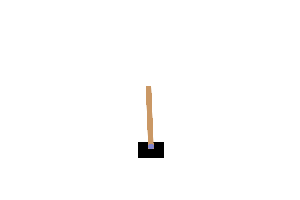

In [42]:
#|hide
#|eval: false
model.eval()

pipe = GymDataPipe(['CartPole-v1']*1,agent=agent,n=1000,seed=0,include_images=True)
pipe = VSCodeDataPipe(pipe)

list(pipe);
pipe.show()
# list(pipe)

In [44]:
# Setup Loggers
def logger_bases(pipe):
    pipe = pipe.dump_records()
    pipe = ProgressBarLogger(
        pipe,
        epoch_on_pipe=EpochCollector,
        batch_on_pipe=BatchCollector
    )
    return pipe

# Setup up the core NN
torch.manual_seed(0)
model = DQN(8,4)
# Setup the Agent
agent = DQNAgent(model,do_logging=True)
# Setup the DataBlock
dls = dataloaders(
    GymDataPipe(['LunarLander-v2']*1,agent=agent,n=1000,bs=1)
)

# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=logger_bases,batches=1000)
learner.fit(3)
# learner.fit(30)

loss,episode,rolling_reward,epoch,batch,epsilon


In [45]:
from fastrl.loggers.vscode_visualizers import VSCodeDataPipe

Creating gif from 1000 frames


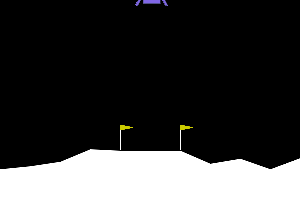

In [46]:
#|hide
#|eval: false
pipe = GymDataPipe(['LunarLander-v2']*1,agent=agent,n=1000,bs=1,include_images=True)
pipe = VSCodeDataPipe(pipe)

list(pipe);
pipe.show(step=2)

In [47]:
#|hide
#|eval: false
!nbdev_export

/usr/local/lib/python3.8/dist-packages/nbdev/export.py:54: UserWarning: Notebook '/home/fastrl_user/fastrl/nbs/07_Agents/02_Continuous/12u_agents.ppo.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
